<a href="https://colab.research.google.com/github/dpapontem/Tareas_minerias1/blob/main/Copia_de_Reg_ejregresion_sinc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Ejemplo mínimos cuadrados para regresión y su extensión no lineal

[sklearn.linear model.LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

Regresor lineal por mínimos cuadrados

\begin{equation}
\omega^* = \arg\min_\omega \|y-Xw\|^2_2
\end{equation}


[sklearn.kernel ridge.KernelRidge](https://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html)

Regresor rígido kernel



\begin{equation}
\omega^* = \arg\min_\omega \|y-\Phi \omega\|^2_2 + \alpha\|\omega\|^2_2
\end{equation}

\begin{equation}
\omega^* = (\Phi^\top \Phi+\alpha I)^{-1}\Phi^\top y
\end{equation}


\begin{equation}
\omega^* = \Phi^\top(\Phi \Phi^\top+\alpha I)^{-1}y = k(\cdot)^\top(K+\alpha I)^{-1}y
\end{equation}

# Ejercicio 1

- Presente la solución al problema de optimización kernel ridge (Ver [Kernel Ridge Regression](https://web2.qatar.cmu.edu/~gdicaro/10315-Fall19/additional/welling-notes-on-kernel-ridge.pdf) y [material de apoyo](https://github.com/amalvarezme/AnaliticaDatos/blob/master/6_TopicosAvanzados/introKernels.pdf) págs 8 y 9).

$$\Phi = B$$

$$R = I$$ $$P=?$$ factorizar para que quede $\alpha$

##**Ejemplo** 

- Se pretende generar un modelo de regresión bajo entradas con ruido blanco Gaussiano, con $\mu_\eta=0$, para seguir una función no lineal tipo sinc(x).

- $y = {\rm{sinc}}(x)+\eta$;  
con $\eta\sim p(\eta)=\mathcal{N}(\eta|\mu_\eta,\sigma_\eta^2)=\frac{1}{\sqrt{2\pi\sigma^2_\eta}}\exp\left(\frac{-\|\eta-\mu_\eta\|_2^2}{2\sigma^2_\eta}\right)$

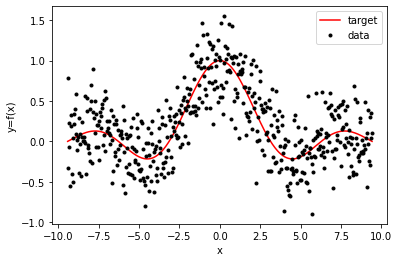

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
N = 500 #número de muestras
X = np.linspace(-3*np.pi,3*np.pi,N) #vector de entrada 
y = np.sinc(X/np.pi) #función sinc -> objetivo
var = 0.1 #varianza del ruido
mue = 0 #media del ruido
noise = mue + np.sqrt(var)*np.random.randn(X.shape[0])#ruido blanco
yn = y + noise #señal co ruido
plt.plot(X,y,'r',label='target' )
plt.plot(X,yn,'k.',label='data')
plt.legend()
plt.xlabel('x')
plt.ylabel('y=f(x)')
plt.show()

**Nota:** $${\rm{sinc}}(\theta)=\frac{\sin(\theta)}{\theta}$$

- Se crean los vectores de entrada y salida tipo aprendizaje de máquina.

In [3]:
ydata = yn.reshape(-1,1)
Xdata = X.reshape(-1,1)
print(Xdata.shape) # N = 500 muestras, P = 1 atributos
print(ydata.shape) # N = 500, regresion univarida

(500, 1)
(500, 1)


- Se entrenará un modelo de aprendizaje con scikitlearn

(350, 1)
(150, 1)


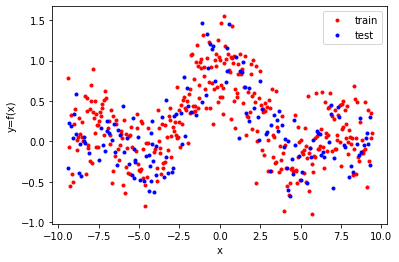

In [4]:
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, cross_val_predict

X_train, X_test, y_train, y_test = train_test_split(Xdata, ydata,
                                                    test_size=0.3)#particionar train y test

print(X_train.shape)
print(X_test.shape)

plt.plot(X_train,y_train,'r.',label='train' )
plt.plot(X_test,y_test,'b.',label='test')
plt.legend()
plt.xlabel('x')
plt.ylabel('y=f(x)')
plt.show()

- Se utilizará el modelo [KernelRidge](https://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html) con función kernel tipo radial basis function (rbf):


$$\kappa(x,x') = \exp\left(\frac{-\gamma\|x-x'\|^2_2}{2}\right)$$

**Nota:** el hiperparámetro $\gamma\in\mathbb{R}^+$ se conoce como precisión y pretende escalar la noción de parecido entre los puntos. La precisión se relaciona comunmente con el parámetro ancho de banda ("varianza") $\sigma\in\mathbb{R}^+$ del modelo rbf, según:

$$\gamma=\frac{1}{\sigma^2}$$

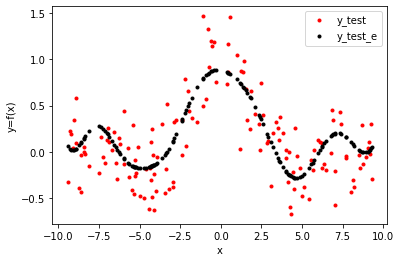

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import Pipeline
gamma = 0.1 #gamma
alpha = 0.001 # valor de regularización
reg = KernelRidge(kernel='rbf',gamma=gamma, alpha = alpha)
reg.fit(X_train,y_train) #ajustar solo sobre train
#prediccion
y_test_e = reg.predict(X_test)
y_train_e = reg.predict(X_train)

plt.plot(X_test,y_test,'r.',label='y_test' )
plt.plot(X_test,y_test_e,'k.',label='y_test_e')
plt.legend()
plt.xlabel('x')
plt.ylabel('y=f(x)')
plt.show()

- Es  necesario encontar unos buenos hiperparámetros para seguir la función no lineal

In [6]:
steps=[('reg', KernelRidge(kernel = 'rbf'))]
parameters = {'reg__alpha' : [0,1e-3,1e-2,0.1,1,10,100,1000],              
              'reg__gamma': [1e-4,1e-3,1e-2,0.1,1,10,100,1000],
              }

pipeline = Pipeline(steps = steps)

grid_search = GridSearchCV(pipeline, parameters, n_jobs=4,cv=10,
                           scoring='neg_mean_absolute_error',verbose=10,refit=True)

grid_search.fit(X_train, y_train)
#mejor modelo entrenado
best_model = grid_search.best_estimator_

print("\nMejores parámetros:\n")
print(grid_search.best_params_)

Fitting 10 folds for each of 64 candidates, totalling 640 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Batch computation too fast (0.1936s.) Setting batch_size=2.
[Parallel(n_jobs=4)]: Done  34 tasks      | elapsed:    3.2s
[Parallel(n_jobs=4)]: Batch computation too fast (0.1749s.) Setting batch_size=4.
[Parallel(n_jobs=4)]: Done  56 tasks      | elapsed:    3.6s
[Parallel(n_jobs=4)]: Done 100 tasks      | elapsed:    4.0s
[Parallel(n_jobs=4)]: Done 144 tasks      | elapsed:    4.3s
[Parallel(n_jobs=4)]: Done 196 tasks      | elapsed:    4.7s
[Parallel(n_jobs=4)]: Done 248 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 308 tasks      | elapsed:    5.6s
[Parallel(n_jobs=4)]: Done 368 tasks      | elapsed:    6.0s
[Parallel(n_jobs=4)]: Done 43


Mejores parámetros:

{'reg__alpha': 0.1, 'reg__gamma': 0.1}


[Parallel(n_jobs=4)]: Done 640 out of 640 | elapsed:    8.1s finished


- Se evaluan los datos de test y train con el mejor modelo encontrado

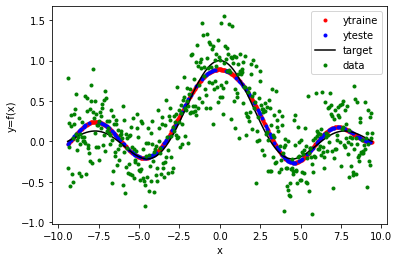

In [7]:
y_test_e = grid_search.best_estimator_.predict(X_test)
y_train_e = grid_search.best_estimator_.predict(X_train)
plt.plot(X_train,y_train_e,'r.',label='ytraine' )
plt.plot(X_test,y_test_e,'b.',label='yteste')
plt.plot(X,y,'k',label='target' )
plt.plot(Xdata,ydata,'g.',label='data' )
plt.legend()
plt.xlabel('x')
plt.ylabel('y=f(x)')
plt.show()

- Visualicemos la función kernel:

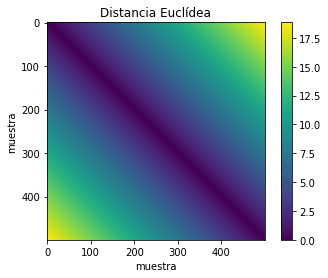

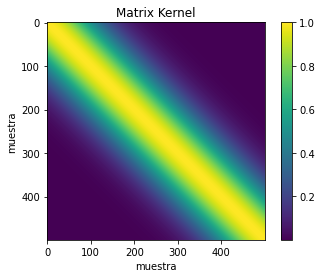

In [8]:
from sklearn.metrics import pairwise_distances as dist

D = dist(X.reshape(-1,1),X.reshape(-1,1)) #disimilitud
K = np.exp(-.5*gamma*D**2)
D.shape
plt.imshow(D)
plt.colorbar()
plt.xlabel('muestra')
plt.ylabel('muestra')
plt.title('Distancia Euclídea')
plt.show()

plt.imshow(K)
plt.colorbar()
plt.xlabel('muestra')
plt.ylabel('muestra')
plt.title('Matrix Kernel')
plt.show()

Recuerde que:

\begin{equation}
\kappa(x,x') = \frac{1}{\sqrt{2\pi \sigma^2}}\exp\left(\frac{-\|x-x'\|_2^2}{2\sigma^2}\right) = \frac{1}{\sqrt{2\pi \sigma^2}}\exp\left(\frac{-\gamma\|x-x'\|_2^2}{2}\right) 
\end{equation}

#Ejercicio 2 

- Visualice el kernel rbf para diferentes condiciones de ruido sintonizando los hiperparámetros del modelo utilizando gridsearch. *Ayuda*: modifique la varianza del ruido.

- Realice una descomposición en valores propios de la matriz kernel para cada una de las condiciones de ruido del punto anterior, qué puede discutir sobre el espectro de la matríz y su influencia en el modelo predictivo de kernel ridge?. Cuál es la relación entre el espectro visualizado y el hiperparámetro de regularización o penalidad encontrado por gridsearch en cada caso?. *Ayuda*: utilizando numpy encuentre la descomposición de valores y vectores propios de $\mathbf{K}$ y $\mathbf{K}+\alpha\mathbf{I}$, según los valores de $\gamma$ y $\alpha$ encontrados por GridsearchCV ante cada condición de ruido evaluada.




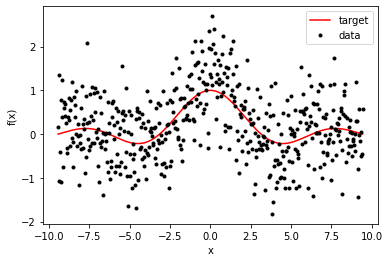

In [36]:
#Ayuda de código:
N = 500 #número de muestras
X = np.linspace(-3*np.pi,3*np.pi,N) #vector de entrada 
y = np.sinc(X/np.pi) #función sinc -> objetivo
var = 0.5 #varianza del ruido-> PROBAR DISTINTOS VALORES
mue = 0 #media del ruido
noise = mue + np.sqrt(var)*np.random.randn(X.shape[0])#ruido blanco
yn = y + noise #señal co ruido
plt.plot(X,y,'r',label='target' )
plt.plot(X,yn,'k.',label='data')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.show()

In [13]:
Xdata = X.reshape(-1,1) #N=500, P= 1
y = y.reshape(-1,1)
ydata = yn.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(Xdata, ydata,
                                                    test_size=0.3)#particionar train y test

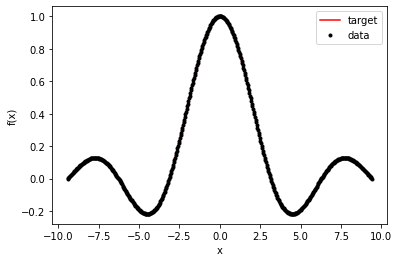

Fitting 10 folds for each of 64 candidates, totalling 640 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Batch computation too fast (0.0340s.) Setting batch_size=2.
[Parallel(n_jobs=4)]: Batch computation too fast (0.0340s.) Setting batch_size=4.
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  32 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done  60 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done  96 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 132 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 176 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 220 tasks      | elapsed:    2.3s
[Parallel(n_jobs=4)]: Done 272 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 324 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done 384 tasks      | elapsed:    3.6s
[Parallel(n_jobs=4)]: Done 44


Mejores parámetros:

{'reg__alpha': 0, 'reg__gamma': 1}


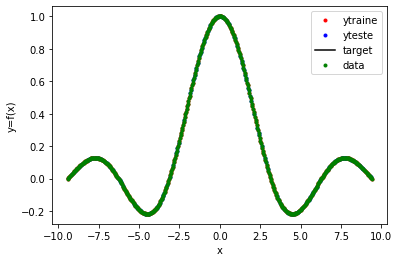

este es el gama que se esta utilizando:  1


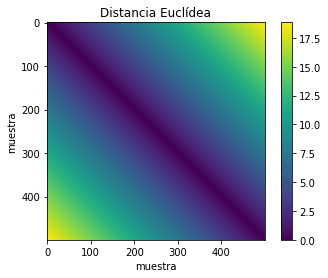

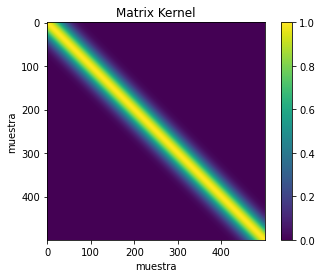

aplpha con el cual se esta trabajando:  0
VALORES PROPIOS ORIGINALES


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:84: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


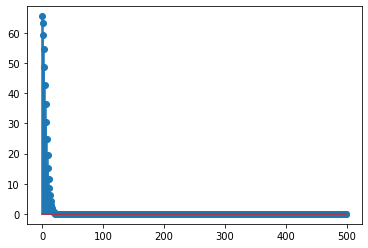

VALORES PROPIOS CON EL ALPHA ENCONTRADA POR EL ALGORITMO


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


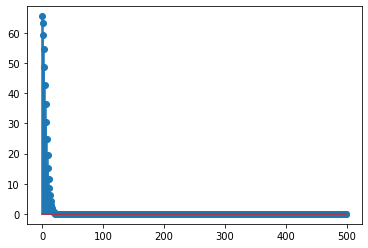

-----final de los resultados-------


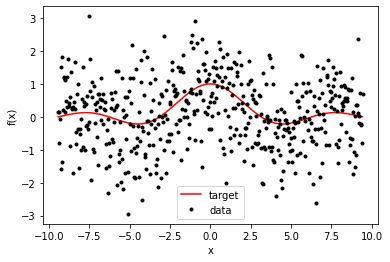

Fitting 10 folds for each of 64 candidates, totalling 640 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Batch computation too fast (0.0407s.) Setting batch_size=2.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  26 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  40 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done  58 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Batch computation too fast (0.1943s.) Setting batch_size=4.
[Parallel(n_jobs=4)]: Done 100 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Batch computation too fast (0.1402s.) Setting batch_size=8.
[Parallel(n_jobs=4)]: Done 160 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 264 tasks      | elapsed:    2.9s
[Parallel(n_jobs=4)]: Done 368 tasks      | elapsed:    3.6s
[Parallel(n_jobs=4)]: Done 488 tasks      | elapsed:    4.4s
[Paralle


Mejores parámetros:

{'reg__alpha': 10, 'reg__gamma': 0.1}


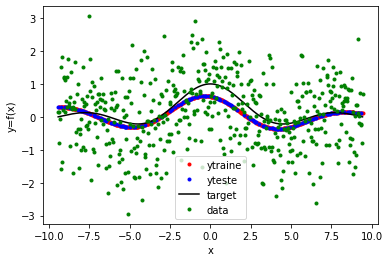

este es el gama que se esta utilizando:  0.1


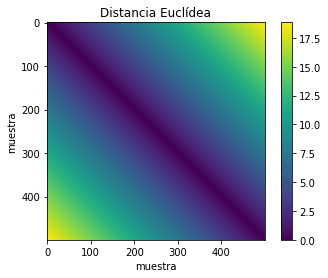

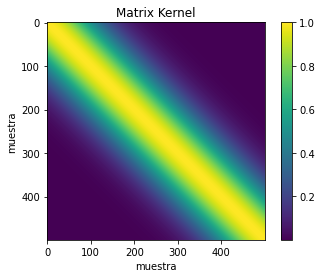

aplpha con el cual se esta trabajando:  10
VALORES PROPIOS ORIGINALES


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:84: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


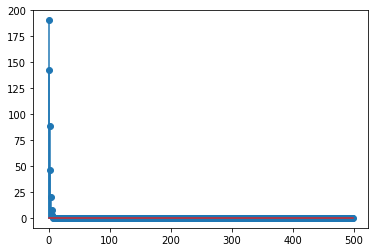

VALORES PROPIOS CON EL ALPHA ENCONTRADA POR EL ALGORITMO


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


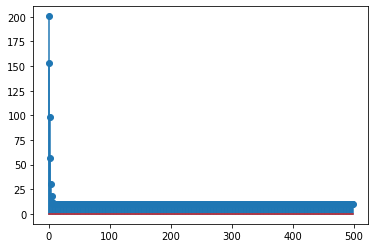

-----final de los resultados-------


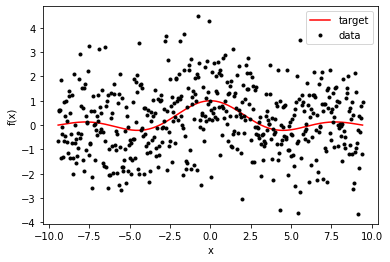

Fitting 10 folds for each of 64 candidates, totalling 640 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Batch computation too fast (0.0522s.) Setting batch_size=2.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  26 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done  40 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done  58 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Batch computation too fast (0.1951s.) Setting batch_size=4.
[Parallel(n_jobs=4)]: Done 100 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Batch computation too fast (0.1635s.) Setting batch_size=8.
[Parallel(n_jobs=4)]: Done 160 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 264 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 368 tasks      | elapsed:    3.5s
[Parallel(n_jobs=4)]: Done 488 tasks      | elapsed:    4.3s
[Paralle


Mejores parámetros:

{'reg__alpha': 10, 'reg__gamma': 0.1}


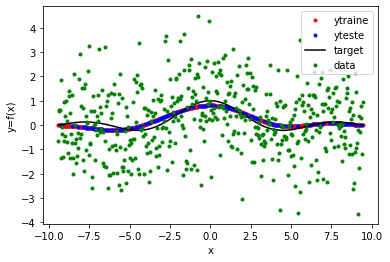

este es el gama que se esta utilizando:  0.1


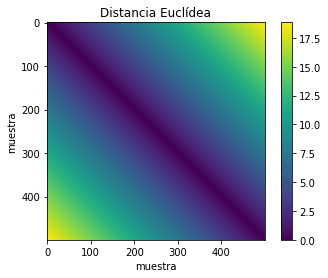

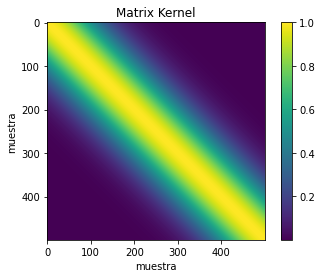

aplpha con el cual se esta trabajando:  10
VALORES PROPIOS ORIGINALES


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:84: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


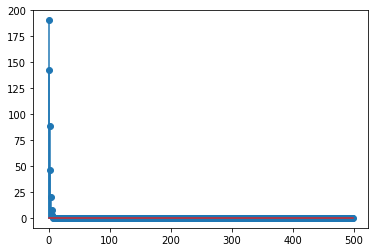

VALORES PROPIOS CON EL ALPHA ENCONTRADA POR EL ALGORITMO


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


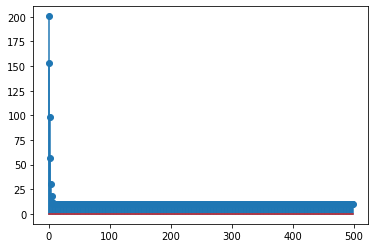

-----final de los resultados-------


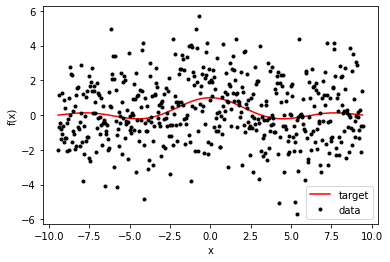

Fitting 10 folds for each of 64 candidates, totalling 640 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Batch computation too fast (0.0790s.) Setting batch_size=2.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  26 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done  40 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done  58 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Batch computation too fast (0.1964s.) Setting batch_size=4.
[Parallel(n_jobs=4)]: Done 100 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Batch computation too fast (0.1125s.) Setting batch_size=8.
[Parallel(n_jobs=4)]: Done 160 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 264 tasks      | elapsed:    2.9s
[Parallel(n_jobs=4)]: Done 368 tasks      | elapsed:    3.6s
[Parallel(n_jobs=4)]: Done 488 tasks      | elapsed:    4.5s
[Paralle


Mejores parámetros:

{'reg__alpha': 10, 'reg__gamma': 1}


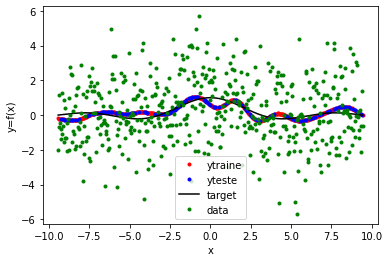

este es el gama que se esta utilizando:  1


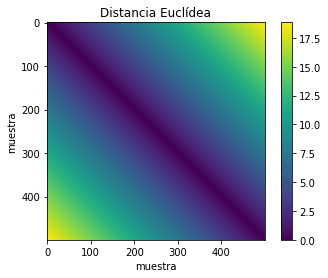

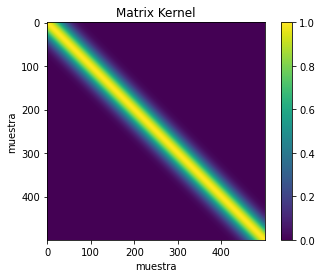

aplpha con el cual se esta trabajando:  10
VALORES PROPIOS ORIGINALES


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:84: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


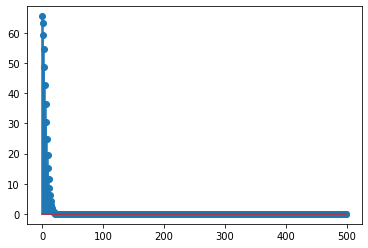

VALORES PROPIOS CON EL ALPHA ENCONTRADA POR EL ALGORITMO


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


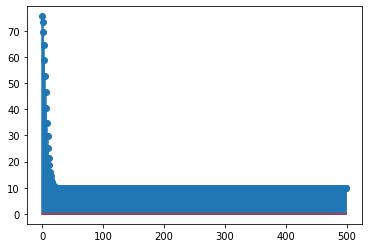

-----final de los resultados-------


In [35]:
def resultados(varianza):

  #Primera parte
  N = 500 #número de muestras
  X = np.linspace(-3*np.pi,3*np.pi,N) #vector de entrada 
  y = np.sinc(X/np.pi) #función sinc -> objetivo
  var = varianza #varianza del ruido-> PROBAR DISTINTOS VALORES
  mue = 0 #media del ruido
  noise = mue + np.sqrt(var)*np.random.randn(X.shape[0])#ruido blanco
  yn = y + noise #señal co ruido
  plt.plot(X,y,'r',label='target' )
  plt.plot(X,yn,'k.',label='data')
  plt.xlabel('x')
  plt.ylabel('f(x)')
  plt.legend()
  plt.show()

  #particionar
  Xdata = X.reshape(-1,1) #N=500, P= 1
  y = y.reshape(-1,1)
  ydata = yn.reshape(-1,1)

  X_train, X_test, y_train, y_test = train_test_split(Xdata, ydata,
                                                      test_size=0.3)#particionar train y test

  #segunda parte
  steps=[('reg', KernelRidge(kernel = 'rbf'))]
  parameters = {'reg__alpha' : [0,1e-3,1e-2,0.1,1,10,100,1000],              
                'reg__gamma': [1e-4,1e-3,1e-2,0.1,1,10,100,1000],
                }

  pipeline = Pipeline(steps = steps)

  grid_search = GridSearchCV(pipeline, parameters, n_jobs=4,cv=10,
                            scoring='neg_mean_absolute_error',verbose=10,refit=True)

  grid_search.fit(X_train, y_train)
  #mejor modelo entrenado
  best_model = grid_search.best_estimator_
  mejores_parametros = grid_search.best_params_
  print("\nMejores parámetros:\n")
  print(mejores_parametros)

  #tercera parte

  y_test_e = grid_search.best_estimator_.predict(X_test)
  y_train_e = grid_search.best_estimator_.predict(X_train)
  plt.plot(X_train,y_train_e,'r.',label='ytraine' )
  plt.plot(X_test,y_test_e,'b.',label='yteste')
  plt.plot(X,y,'k',label='target' )
  plt.plot(Xdata,ydata,'g.',label='data' )
  plt.legend()
  plt.xlabel('x')
  plt.ylabel('y=f(x)')
  plt.show()
  
  #cuarta parte
  gamma= mejores_parametros['reg__gamma']
  alfa=mejores_parametros['reg__alpha']
  print("este es el gama que se esta utilizando: ", gamma)
  D = dist(X.reshape(-1,1),X.reshape(-1,1)) #disimilitud
  K = np.exp(-.5*gamma*D**2)
  D.shape
  plt.imshow(D)
  plt.colorbar()
  plt.xlabel('muestra')
  plt.ylabel('muestra')
  plt.title('Distancia Euclídea')
  plt.show()

  plt.imshow(K)
  plt.colorbar()
  plt.xlabel('muestra')
  plt.ylabel('muestra')
  plt.title('Matrix Kernel')
  plt.show()

  #Segundo punto punto valores propioas
  print("aplpha con el cual se esta trabajando: ", alfa)
  Kalpha = K + alfa*np.eye(N)
  val,vec = np.linalg.eig(K)
  val_a,vec_a = np.linalg.eig(Kalpha)
  print("VALORES PROPIOS ORIGINALES")
  plt.stem(val)
  plt.show()

  print("VALORES PROPIOS CON EL ALPHA ENCONTRADA POR EL ALGORITMO")

  plt.stem(val_a)
  plt.show()
  print('-----final de los resultados-------')

varN = [0.01, 0.2, 0.5, 0.03]

for i in range(len(varN)):
  resultados(i)


